<br>
<br>

Introduction
==========

Put some introduction here. 

<br>
<br>


In [1]:
# import required modules/packages

import os
import string
import subprocess
import numpy as np
from collections import OrderedDict
import math
import pandas as pd
import geopandas as gpd
from scipy.spatial import Delaunay
from shapely.geometry import MultiLineString
from shapely.ops import cascaded_union, polygonize
import time

import pcraster as pcr

import matplotlib

#%matplotlib notebook
#TODO: Note that pcr.plot() still does not support interactive zoom-ing.    


In [2]:
# check the path and test aguila
print(os.environ["PATH"])
path_saved=os.environ["PATH"]

# test aguila 
pcr.aguila()
!aguila

/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (8 8 8 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 8 8 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 1 8 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 1 1 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 1 1 0)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFor

In [11]:
# if needed, fix the path: pcraster should be the first #TODO: Investigate why we need this?
os.environ["PATH"] = path_saved
os.environ["PATH"] = "/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin"
pcr.aguila()
!aguila

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (8 8 8 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 8 8 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 1 8 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 1 1 0)
qt.glx: qglx_findConfig: Failed to finding matching FBConfig (1 1 1 0)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


In [4]:
# import sub-modules

import mapIO
import pcrRecipes
import measures_py3 as msr


<br>
<br>

Please define output and input folders.

In [5]:
# - for test on cartesius
# output_dir  = "/scratch/depfg/sutan101/tmp_menno/out/"
# input_dir   = "/scratch/depfg/hydrowld/river_scape/source/from_menno/riverscape/input/"
# scratch_dir = "/scratch/depfg/sutan101/tmp_menno/tmp/"

# - for test on fleet
output_dir  = "/scratch/sutan101/tmp_menno/out/"
input_dir   = "/home/sutan101/data/river_scape/source/from_menno/riverscape/input/"
scratch_dir = output_dir + "/tmp/"


<br>

Please define your input (a separate manual is encouraged here).


In [6]:
#-define input
settings = OrderedDict([
                    ('smoothing_percentage', 100),
                    ('smoothing_ecotope', 'UG-2'),
                    ('smoothing_trachytope', 1201),
                    
                    ('lowering_percentage', 100),
                    ('lowering_ecotope', 'UG-2'),
                    ('lowering_trachytope', 1201),
                    ('lowering_height', 'water_level_50d'),
                    
                    ('channel_width', 75),
                    ('channel_depth', 2.5),
                    ('channel_slope', 1./3.),
                    ('channel_ecotope', 'RnM'),
                    ('channel_trachytope', 105),
                    
                    ('relocation_alpha', 10000),
                    ('relocation_depth', 'AHN'),
                    ('relocation_ecotope', 'HG-2'),
                    ('relocation_trachytope', 1201),
                    
                    ('groyne_ref_level', 'wl_exc150d'),
                    ('minemb_ref_level', 'wl_exc50d'),
                    ('main_dike_dh', 0.50),
                    ])


<br>

Start processing/calculation ....
========================

<br>


In [7]:
# starting time of this script
start_time = time.time()

In [8]:
# set global option for pcraster such that length of cells is computed in true length of cells
pcr.setglobaloption('unittrue')
# TODO: Check with Menno why we need this?

In [9]:
# set the pcraster clone map
current_dir = os.path.join(input_dir, 'reference_maps')
pcr.setclone(os.path.join(current_dir, 'clone.map'))

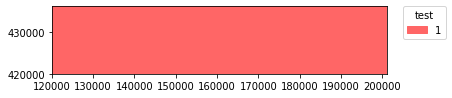

/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin


In [12]:
# check and plot the clone map
test = pcr.readmap(os.path.join(current_dir, 'clone.map'))

pcr.aguila(test)
pcr.plot(test) 

!echo $PATH

In [13]:
# import data
main_dike = msr.read_dike_maps(current_dir, 'main_dike')
minemb = msr.read_dike_maps(current_dir, 'minemb')
groynes = msr.read_dike_maps(current_dir, 'groyne')
hydro = msr.read_hydro_maps(current_dir)
mesh = msr.read_mesh_maps(current_dir)
axis = msr.read_axis_maps(current_dir)
lulc = msr.read_lulc_maps(current_dir)
geom = msr.read_geom_maps(current_dir)

In [14]:
# make scratch directory and go to this folder
pcrRecipes.make_dir(scratch_dir)
os.chdir(scratch_dir)

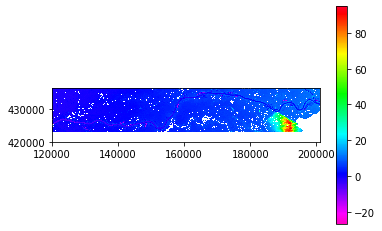

In [15]:
# plot the digital elevation model
pcr.aguila(geom.dem)
pcr.plot(geom.dem)

In [16]:
# initiate the model
waal = msr.River('Waal', axis, main_dike, minemb, groynes, hydro, 
             mesh, lulc, geom)
waal_msr = msr.RiverMeasures(waal)
waal_msr.settings = settings

In [17]:
# define the mask and ID
mask = pcr.boolean(1)
ID = 'everywhere'

In [18]:
# lowering meause
lowering_msr = waal_msr.lowering_measure(settings, mask=mask, ID=ID)

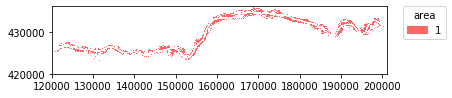

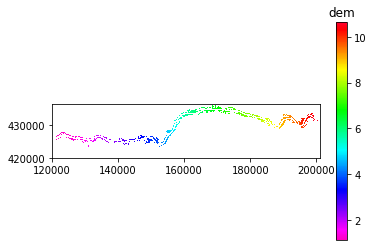

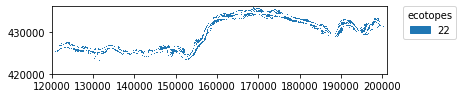

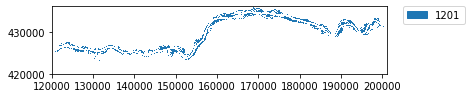

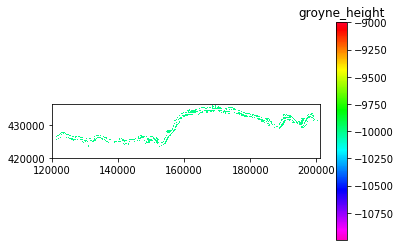

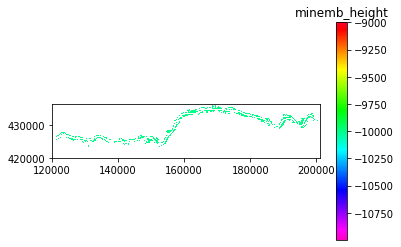

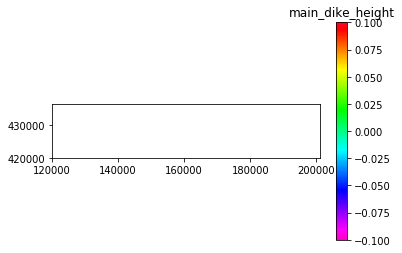

In [19]:
# plot/explore lowering measure
lowering_msr.plot()

In [21]:
# close all aguila 
os.system("killall aguila")
os.system("ls")
!echo $PATH

/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin


In [22]:
groyne_low_msr = waal_msr.groyne_lowering_msr(settings, mask=mask, ID=ID)

In [23]:
minemb_low_msr = waal_msr.minemb_lowering_msr(settings, mask=mask, ID=ID)

In [24]:
main_dike_raise_msr = waal_msr.main_dike_raising_msr(settings, mask=mask, ID=ID)

In [25]:
large_sections = pcr.ifthen(pcr.areaarea(waal.geom.flpl_wide) > 1e6, waal.geom.flpl_wide)
flpl_section = pcr.ifthen(large_sections == 1, pcr.nominal(1))

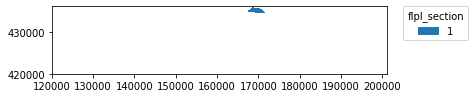

In [26]:
pcr.aguila(flpl_section)
pcr.plot(flpl_section)

In [27]:
test = list(np.unique(pcr.pcr2numpy(large_sections, -9999))[1:])
test[:]
for ID in test[:]:
    print(ID)

1
2
3
5
6
8
10
12
13
14
17
18
20
21
22
23
27
29
30
35
39
40
43
44
49
54
56


In [28]:
chan_msr = waal_msr.side_channel_measure(settings, mask=mask, ID=ID)

[1, 2, 3, 8, 10, 13, 14, 18, 20, 22, 23, 27, 30, 39, 40, 43, 49, 54, 56]
1
2
3
8
10
13
14
18
20
22
23
27
30
39
40
43
49
54
56


In [29]:
os.system("killall aguila")

256

In [30]:
smooth_msr = waal_msr.smoothing_measure(settings, mask=mask, ID=ID)

In [31]:
msr_list = [groyne_low_msr, minemb_low_msr,
            main_dike_raise_msr, lowering_msr, chan_msr, smooth_msr]

In [32]:
msr_root_dir = os.path.join(output_dir, 'measures_ensemble03/maps')

In [33]:
pcrRecipes.make_dir(msr_root_dir)

In [34]:
from measures_py3 import *

In [35]:
for measure in msr_list:
    write_measure(measure, msr_root_dir)

/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/groynelowering_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/minemblowering_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/dikeraising_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/lowering_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/sidechannel_56
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/smoothing_56
